# Applying PSO for Feature Selection

## Goal:
Using PSO to automatically select the most relevant features from a dataset to maximize classification accuracy, and reduce feature dimensionality.

## Particle Swarm Optimization (PSO)
Particle Swarm Optimization (PSO) is a metaheuristic optimization algorithm inspired by the collective behavior of birds and fish moving in swarms.

Originally developed by Kennedy and Eberhart (1995), PSO is widely used to solve continuous and discrete optimization problems, especially when the objective function is complex, non-linear, or without derivatives.

* Each solution is modeled as a **particle** in a search space.

A particle has:

 - A position (candidate solution)

* A velocity (direction and speed of movement)

Each particle updates its position based on:

* Its own best position so far (pbest)

* The best known position found by the swarm (gbest)

##🔁 Algorithm Steps:
1. Initialize a swarm of particles with random binary positions.

2. For each particle:

- Use the binary mask to select features.

- Train a classifier on the selected features.

- Evaluate model accuracy via cross-validation.

3. Update the personal best (pbest) and global best (gbest).

4. Update the velocity and position of each particle.

5. Repeat for a number of iterations or until convergence.

6. Return the best binary mask found – this represents the optimal feature subset.



#Including libraries

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
import seaborn as sns

#Loading and processing data

In [17]:
def load_and_preprocess_data(filepath):
    """Load and preprocess the dataset"""
    # Load data without headers
    df = pd.read_csv('Breast.csv', header=None)

    # Extract features and target
    X = df.iloc[:, :-1].values  # All columns except last
    y = df.iloc[:, -1].values   # Last column as target

    # Scale features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    return X_scaled, y, df.shape[1]-1  # Return features, target, and num_features

In [21]:
def evaluate_classifiers(X, y):
    """Evaluate multiple classifiers and return results"""
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42
    )

    # Initialize classifiers
    classifiers = {
        'KNN': KNeighborsClassifier(n_neighbors=5),
        'SVM': SVC(kernel='rbf', random_state=42),
        'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
        'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
        'Decision Tree': DecisionTreeClassifier(random_state=42)
    }

    results = {}

    # Train and evaluate each classifier
    for name, clf in classifiers.items():
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        results[name] = accuracy

        print(f"{name} Accuracy: {accuracy:.4f}")
        print(classification_report(y_test, y_pred))
        print("="*60)

    return results, classifiers

def plot_model_comparison(results):
    """Visualize classifier performance comparison"""
    plt.figure(figsize=(10, 6))
    sns.barplot(x=list(results.keys()), y=list(results.values()))
    plt.title('Classifier Accuracy Comparison')
    plt.ylabel('Accuracy')
    plt.ylim(0.0, 1.0)  # Adjust based on your results
    plt.xticks(rotation=45)
    plt.show()



Dataset loaded with 24482 features and 97 samples

Evaluating multiple classifiers...
KNN Accuracy: 0.5000
              precision    recall  f1-score   support

           0       0.48      0.71      0.57        14
           1       0.56      0.31      0.40        16

    accuracy                           0.50        30
   macro avg       0.52      0.51      0.49        30
weighted avg       0.52      0.50      0.48        30

SVM Accuracy: 0.6333
              precision    recall  f1-score   support

           0       0.58      0.79      0.67        14
           1       0.73      0.50      0.59        16

    accuracy                           0.63        30
   macro avg       0.65      0.64      0.63        30
weighted avg       0.66      0.63      0.63        30

Random Forest Accuracy: 0.6333
              precision    recall  f1-score   support

           0       0.57      0.93      0.70        14
           1       0.86      0.38      0.52        16

    accuracy          

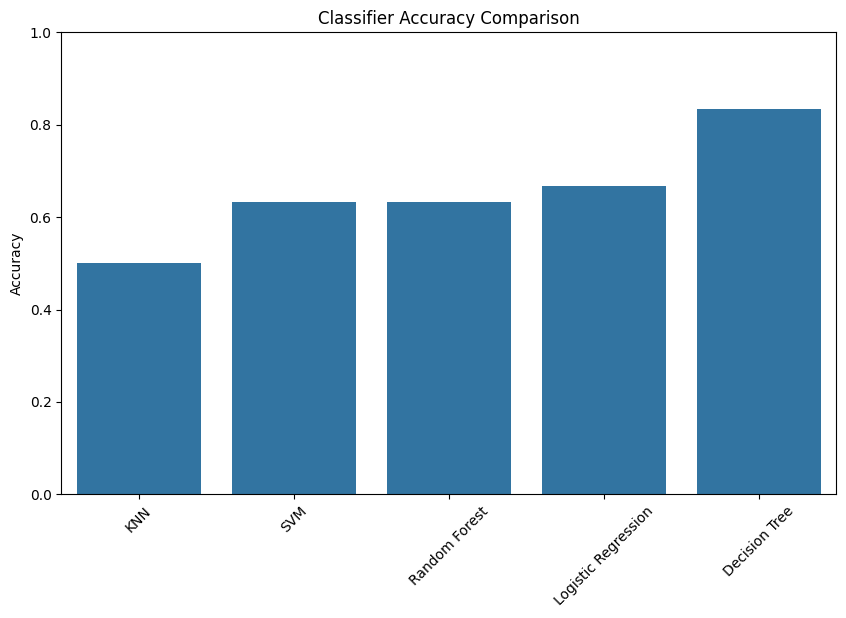

In [22]:
# 1. Load and preprocess data
X, y, num_features = load_and_preprocess_data('Breast.csv')
print(f"\nDataset loaded with {num_features} features and {len(y)} samples")

# 2. Compare classifiers
print("\nEvaluating multiple classifiers...")
results, classifiers = evaluate_classifiers(X, y)
plot_model_comparison(results)

# Using PSO for better feature selection for KNN classifier

##Initialize the Swarm
Each particle's position represents a potential feature subset, where each dimension corresponds to a feature (1 = selected, 0 = not selected).

In [23]:
def initialize_swarm(n_particles, n_features):
    """Initialize swarm with random positions and velocities"""
    positions = np.random.rand(n_particles, n_features)
    velocities = np.random.uniform(-1, 1, (n_particles, n_features))
    return positions, velocities

##Define the Fitness Function
The fitness function evaluates how good a solution (feature subset) is. We'll use classification accuracy as the primary metric with a penalty for large feature subsets.

In [24]:
def evaluate_fitness(position, X_train, y_train, X_test, y_test, alpha=0.01):
    """Evaluate fitness of a particle's position"""
    selected = position > 0.5  # Convert continuous to binary

    if np.sum(selected) == 0:  # At least one feature must be selected
        return -np.inf, 0  # Return fitness and accuracy

    # Get selected features
    X_train_selected = X_train[:, selected]
    X_test_selected = X_test[:, selected]

    # Train and evaluate model
    clf = KNeighborsClassifier(n_neighbors=5)
    clf.fit(X_train_selected, y_train)
    y_pred = clf.predict(X_test_selected)
    accuracy = accuracy_score(y_test, y_pred)

    # Balance accuracy and feature count
    n_selected = np.sum(selected)
    n_total = X_train.shape[1]
    fitness = accuracy - alpha * (n_selected / n_total)

    return fitness, accuracy  # Return both fitness and actual accuracy

##Core PSO Algorithm (PSO_feature_selection)

In [25]:
def PSO_feature_selection(X, y, n_particles=30, n_iterations=100, w=0.7, c1=1.5, c2=1.5):
    """Perform feature selection using PSO"""
    # Convert to numpy arrays
    X_np = X.values if isinstance(X, pd.DataFrame) else X
    y_np = y.values if isinstance(y, pd.Series) else y

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X_np, y_np, test_size=0.3, random_state=42
    )

    # Initialize swarm
    n_features = X_np.shape[1]
    positions, velocities = initialize_swarm(n_particles, n_features)

    # Initialize best solutions
    personal_best_positions = np.copy(positions)
    personal_best_fitness = np.array([-np.inf] * n_particles)
    personal_best_accuracy = np.array([0] * n_particles)
    global_best_position = None
    global_best_fitness = -np.inf
    global_best_accuracy = 0
    fitness_history = []
    accuracy_history = []

    # PSO main loop
    for iteration in range(n_iterations):
        for i in range(n_particles):
            current_fitness, current_accuracy = evaluate_fitness(
                positions[i], X_train, y_train, X_test, y_test
            )

            # Update personal best
            if current_fitness > personal_best_fitness[i]:
                personal_best_fitness[i] = current_fitness
                personal_best_accuracy[i] = current_accuracy
                personal_best_positions[i] = positions[i].copy()

                # Update global best
                if current_fitness > global_best_fitness:
                    global_best_fitness = current_fitness
                    global_best_accuracy = current_accuracy
                    global_best_position = positions[i].copy()

        # Update velocities and positions
        for i in range(n_particles):
            r1, r2 = np.random.rand(2)
            cognitive = c1 * r1 * (personal_best_positions[i] - positions[i])
            social = c2 * r2 * (global_best_position - positions[i])

            velocities[i] = w * velocities[i] + cognitive + social
            positions[i] = positions[i] + velocities[i]
            positions[i] = np.clip(positions[i], 0, 1)  # Keep in [0,1] range

        fitness_history.append(global_best_fitness)
        accuracy_history.append(global_best_accuracy)

        #if (iteration + 1) % 10 == 0:
        #    print(f"Iteration {iteration + 1}, Best Accuracy: {global_best_accuracy:.4f}")

    # Convert to binary feature selection
    best_features = global_best_position > 0.5

    return best_features, fitness_history, accuracy_history, global_best_accuracy




* **Velocity** In PSO, velocity determines how a particle moves in the search space.

Each particle has a position (current solution) and a velocity (direction and speed of movement).

* Velocity is updated based on:

-Inertia (w × current velocity): Keeps the particle moving in its current direction.

-Cognitive component (c1 × r1 × (personal_best - current)): Moves toward the particle’s best-known position.

-Social component (c2 × r2 × (global_best - current)): Moves toward the swarm’s best-known position.

##Iterative Feature Selection
Applies PSO multiple times, each time using only features selected in previous round

Stops when accuracy stops improving significantly

In [26]:
def run_iterative_feature_selection(X, y, max_rounds=10, n_particles=30, n_iterations=100, min_improvement=0.01):
    """Run PSO feature selection iteratively until accuracy stops improving"""
    current_X = X.copy()
    feature_history = []
    round_accuracies = []
    best_accuracy = 0
    best_round_data = None  # To store the best round's data

    for round_num in range(1, max_rounds + 1):
        print(f"\n=== Feature Selection Round {round_num} ===")
        print(f"Starting with {current_X.shape[1]} features")

        # Run PSO
        best_features, _, _, round_accuracy = PSO_feature_selection(
            current_X, y,
            n_particles=n_particles,
            n_iterations=n_iterations
        )

        # Store this round's data
        current_round_data = {
            'features': best_features.copy(),
            'accuracy': round_accuracy,
            'X_selected': current_X[:, best_features] if not isinstance(current_X, pd.DataFrame)
                          else current_X[current_X.columns[best_features]].copy()
        }

        # Check if improvement is significant
        if round_num > 1 and (round_accuracy - best_accuracy) < min_improvement:
            print(f"Stopping early - accuracy improvement less than {min_improvement:.4f}")
            # Use the previous round's data since this round didn't improve enough
            break

        # Update best accuracy and store this as the best round so far
        if round_accuracy > best_accuracy:
            best_accuracy = round_accuracy
            best_round_data = current_round_data

        round_accuracies.append(round_accuracy)

        # Get selected feature indices
        if isinstance(current_X, pd.DataFrame):
            selected_features = current_X.columns[best_features].tolist()
            current_X = current_X[selected_features]
        else:
            selected_features = np.where(best_features)[0].tolist()
            current_X = current_X[:, best_features]

        feature_history.append(selected_features)
        print(f"Selected {len(selected_features)} features with accuracy {round_accuracy:.4f}")

        # Early stopping if we've reduced to very few features
        if current_X.shape[1] <= 10:
            print("Stopping early - reached minimum number of features")
            best_round_data = current_round_data  # This is our final round
            break

    # Ensure we return the data from the last valid round
    if best_round_data is None:
        best_round_data = current_round_data

    # Reconstruct the feature history up to the best round
    valid_feature_history = feature_history[:len(round_accuracies)]

    return valid_feature_history, best_round_data['X_selected'], round_accuracies, best_round_data['accuracy']


## Model evaluation

In [27]:
def evaluate_model(X, y, model=KNeighborsClassifier(n_neighbors=5)):
    """Evaluate model performance"""
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42
    )

    # Standardize features
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Train and evaluate
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)

    return accuracy

In [28]:

def main():
    # Load your dataset
    df = pd.read_csv('Breast.csv', header=None)

    # Extract features and target
    X = df.iloc[:, :-1].values
    y = df.iloc[:, -1].values

    # Scale the features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    X = X_scaled

    # Initial evaluation
    full_accuracy = evaluate_model(X, y)
    print(f"\nInitial Accuracy (All Features): {full_accuracy:.4f}")
    print(f"Number of Features: {X.shape[1]}")

    # Run adaptive iterative feature selection
    feature_history, X_selected, round_accuracies, final_accuracy = run_iterative_feature_selection(
        X, y,
        max_rounds=10,
        n_particles=50,
        n_iterations=100,
        min_improvement=0.001
    )

    # Final evaluation (using the exact same features that produced the final accuracy)
    # No need to re-evaluate since we already have the accurate final_accuracy
    print("\n=== Final Results ===")
    print(f"Final Accuracy: {final_accuracy:.4f}")
    print(f"Number of Features: {X_selected.shape[1]}")
    print(f"Rounds Completed: {len(round_accuracies)}")
    print(f"Accuracy Progression: {round_accuracies}")




if __name__ == "__main__":
    main()


Initial Accuracy (All Features): 0.5333
Number of Features: 24482

=== Feature Selection Round 1 ===
Starting with 24482 features
Selected 11963 features with accuracy 0.6333

=== Feature Selection Round 2 ===
Starting with 11963 features
Selected 5782 features with accuracy 0.6667

=== Feature Selection Round 3 ===
Starting with 5782 features
Selected 2760 features with accuracy 0.7000

=== Feature Selection Round 4 ===
Starting with 2760 features
Selected 1324 features with accuracy 0.7667

=== Feature Selection Round 5 ===
Starting with 1324 features
Selected 606 features with accuracy 0.8000

=== Feature Selection Round 6 ===
Starting with 606 features
Selected 273 features with accuracy 0.8667

=== Feature Selection Round 7 ===
Starting with 273 features
Stopping early - accuracy improvement less than 0.0010

=== Final Results ===
Final Accuracy: 0.8667
Number of Features: 273
Rounds Completed: 6
Accuracy Progression: [0.6333333333333333, 0.6666666666666666, 0.7, 0.76666666666666